In [77]:
#!pip install scikit-bio
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from collections import Counter
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.interpolate import interp1d
from sklearn.utils import resample
from scipy.stats import wilcoxon
import math
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform
from skbio.stats.composition import clr
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import braycurtis
from sklearn.manifold import MDS
from functools import reduce

## Load, Explore and prepare the 16s rRNA data 

In [80]:
df = pd.read_csv("16S rRNA.csv")  

In [82]:
df.head()

,sample-id,Patient,Timepoint,c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella,c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides,c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;__,c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Ralstonia,c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae;__,c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Afipia,...,c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__uncultured,c__Clostridia;o__Oscillospirales;f__UCG-010;g__UCG-010,c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcales-Tissierellales;g__Ezakiella,Unassigned.1,c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcales-Tissierellales;g__Finegoldia,c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Anaerovoracaceae;g__Family_XIII_UCG-001,c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__uncultured,Patient.1,Timepoint.1,Fcal
0,1A,1,Baseline,53,11534,0,0,0,3444,0,...,0,0,0,6,0,0,0,1,Baseline,608
1,2A,2,Baseline,0,28833,3567,0,0,0,0,...,0,0,0,0,0,0,0,2,Baseline,912
2,3A,3,Baseline,6374,63481,0,0,0,12282,0,...,0,0,0,0,0,3,0,3,Baseline,2200
3,4A,4,Baseline,422,22733,0,0,0,5105,0,...,0,11,0,0,0,0,0,4,Baseline,2000
4,5A,5,Baseline,19765,18741,1181,0,0,17427,0,...,0,0,0,0,0,0,0,5,Baseline,182


In [84]:
# Step 1: Identify taxonomic columns (adjust indices if needed)
taxa_columns = df.columns[3:-3]  # assuming first 3 are metadata, last 3 are clinical

# Step 2: Extract genus names from column headers
def extract_genus(col):
    for part in col.split(';'):
        if part.startswith("g__"):
            genus_name = part.replace("g__", "") or "Unassigned"
            return "g__" + genus_name
    return "g__Unassigned"

genus_names = [extract_genus(col) for col in taxa_columns]

# Step 3: Subset the DataFrame using valid column names
df_genus = df[taxa_columns].copy()
df_genus.columns = genus_names

# Step 4: Collapse by genus (sum duplicate genus names)
df_genus_grouped = df_genus.groupby(df_genus.columns, axis=1).sum()

# Optional: Add sample ID as index
df_genus_grouped.index = df["sample-id"]

# Step 5: Save or inspect the result
df_genus_grouped.to_csv("collapsed_genus_level.csv")
print(df_genus_grouped.head())

           g__Acidaminococcus  g__Acidibacter  g__Acinetobacter  \
sample-id                                                         
1A                          0               0                 0   
2A                          0               0                 0   
3A                          0               0                 0   
4A                          0               0                 0   
5A                          0               0                 0   

           g__Actinobacillus  g__Actinomyces  g__Afipia  g__Agathobacter  \
sample-id                                                                  
1A                         0               0          0             1174   
2A                         0               0          0                0   
3A                         0               0          0                0   
4A                         0               0          0              750   
5A                         0              19          0             2814  

/var/folders/0_/qg07x0dd5s5dkp59h7mxv64h0000gn/T/ipykernel_1242/2055081877.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_genus_grouped = df_genus.groupby(df_genus.columns, axis=1).sum()


In [86]:
# Assuming your dataframe is called df_family_grouped
df_genus_clean = df_genus_grouped.copy()

# Remove the 'g__' prefix from all column names
df_genus_clean.columns = df_genus_clean.columns.str.replace("g__", "", regex=False)

# Preview the cleaned column names
print(df_genus_clean.columns.tolist()[:10])

['Acidaminococcus', 'Acidibacter', 'Acinetobacter', 'Actinobacillus', 'Actinomyces', 'Afipia', 'Agathobacter', 'Akkermansia', 'Alistipes', 'Alloprevotella']


In [88]:
df_genus_clean.head()

,Acidaminococcus,Acidibacter,Acinetobacter,Actinobacillus,Actinomyces,Afipia,Agathobacter,Akkermansia,Alistipes,Alloprevotella,...,[Eubacterium]_eligens_group,[Eubacterium]_fissicatena_group,[Eubacterium]_hallii_group,[Eubacterium]_siraeum_group,[Eubacterium]_ventriosum_group,[Eubacterium]_xylanophilum_group,[Ruminococcus]_gauvreauii_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,uncultured
sample-id,,,,,,,,,,,,,,,,,,,,,
1A,0,0,0,0,0,0,1174,0,7508,0,...,148,0,0,6,29,0,0,611,0,2448
2A,0,0,0,0,0,0,0,0,121,0,...,0,0,67,0,25,0,0,134,0,0
3A,0,0,0,0,0,0,0,674,93,0,...,0,0,40,0,46,0,0,2330,1196,748
4A,0,0,0,0,0,0,750,129,835,70,...,9,0,77,13,0,0,94,0,116,0
5A,0,0,0,0,19,0,2814,0,263,0,...,129,0,1175,36,28,0,333,91,919,312


In [90]:
df_genus_clean.describe()

,Acidaminococcus,Acidibacter,Acinetobacter,Actinobacillus,Actinomyces,Afipia,Agathobacter,Akkermansia,Alistipes,Alloprevotella,...,[Eubacterium]_eligens_group,[Eubacterium]_fissicatena_group,[Eubacterium]_hallii_group,[Eubacterium]_siraeum_group,[Eubacterium]_ventriosum_group,[Eubacterium]_xylanophilum_group,[Ruminococcus]_gauvreauii_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,uncultured
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0000,30.00000,30.000000,30.00000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,67.333333,20.000000,217.266667,4.033333,2.566667,1795.433333,646.0000,1274.60000,1037.833333,9.90000,...,281.733333,4.433333,104.266667,25.733333,40.766667,41.166667,37.666667,512.966667,270.800000,246.066667
std,359.472155,62.328938,835.981477,16.853289,8.131180,6221.242185,2029.1569,4356.18197,2098.082114,42.94692,...,1244.869497,18.056775,246.811101,129.239135,119.838018,159.986655,84.546389,1445.969726,494.748728,528.713007
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,15.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,321.0000,63.00000,765.500000,0.00000,...,0.000000,0.000000,65.250000,0.000000,27.250000,0.000000,0.000000,251.750000,312.500000,299.250000
max,1970.000000,245.000000,4145.000000,87.000000,35.000000,27446.000000,10903.0000,22764.00000,7560.000000,227.00000,...,6803.000000,96.000000,1175.000000,709.000000,629.000000,741.000000,333.000000,7182.000000,1847.000000,2448.000000


In [92]:
df_genus_clean.isnull().sum().sum()

0

In [94]:
df_genus_clean.shape

(30, 149)

In [96]:
# filtering low-variance / sparse features 

#remove features with 0 > in 80% of samples

sparsity_threshold = 0.8 
filtered_df = df_genus_clean.loc[:, (df_genus_clean == 0).mean() < sparsity_threshold]

In [98]:
filtered_df.shape

(30, 63)

In [100]:
df_genus_clean.head()

,Acidaminococcus,Acidibacter,Acinetobacter,Actinobacillus,Actinomyces,Afipia,Agathobacter,Akkermansia,Alistipes,Alloprevotella,...,[Eubacterium]_eligens_group,[Eubacterium]_fissicatena_group,[Eubacterium]_hallii_group,[Eubacterium]_siraeum_group,[Eubacterium]_ventriosum_group,[Eubacterium]_xylanophilum_group,[Ruminococcus]_gauvreauii_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,uncultured
sample-id,,,,,,,,,,,,,,,,,,,,,
1A,0,0,0,0,0,0,1174,0,7508,0,...,148,0,0,6,29,0,0,611,0,2448
2A,0,0,0,0,0,0,0,0,121,0,...,0,0,67,0,25,0,0,134,0,0
3A,0,0,0,0,0,0,0,674,93,0,...,0,0,40,0,46,0,0,2330,1196,748
4A,0,0,0,0,0,0,750,129,835,70,...,9,0,77,13,0,0,94,0,116,0
5A,0,0,0,0,19,0,2814,0,263,0,...,129,0,1175,36,28,0,333,91,919,312


In [102]:
# Create a new column for Timepoint based on index
filtered_df['Timepoint'] = filtered_df.index.to_series().apply(
    lambda x: 'Baseline' if x.endswith('A') else 'Week 4' if x.endswith('C') else 'Unknown'
)

/var/folders/0_/qg07x0dd5s5dkp59h7mxv64h0000gn/T/ipykernel_1242/2833046001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Timepoint'] = filtered_df.index.to_series().apply(


In [104]:
# Seperate meta data from genus 

genus_timepoint = filtered_df['Timepoint']
genus_info = filtered_df.drop(['Timepoint'], axis = 1)

## Preprocess the 16s rRNA

In [107]:
# Step 1: Add pseudo-count (to avoid zeros)
df_pseudo = genus_info + 1e-5

In [109]:
# Apply clr
df_clr = pd.DataFrame(clr(df_pseudo.values), index=genus_info.index, columns=genus_info.columns)

In [111]:
# Apply min-max scaler 

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clr), index=genus_info.index, columns=genus_info.columns)

In [113]:
# Step 4: Bray-Curtis distance matrix

dist_matrix = squareform(pdist(df_scaled, metric='braycurtis'))

In [115]:
# Your confidence_ellipse function (slightly modified to allow fill)
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', edgecolor='black', **kwargs):
    if x.size <= 2 or np.all(x == x[0]) or np.all(y == y[0]):
        return
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse((mean_x, mean_y), width, height, angle=theta,
                      facecolor=facecolor, edgecolor=edgecolor, **kwargs)
    ax.add_patch(ellipse)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


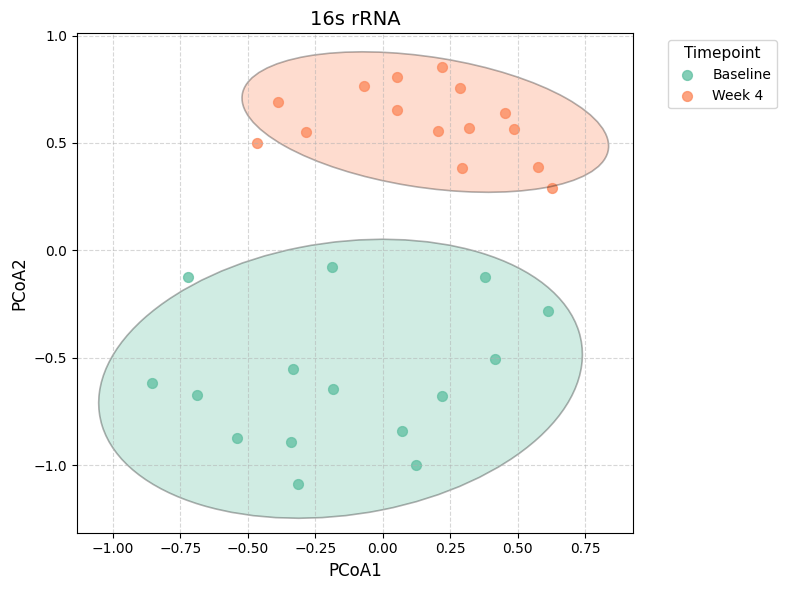

In [117]:
# Step 5: PCoA (using classical MDS)
pcoa = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_coords = pcoa.fit_transform(dist_matrix)  # dist_matrix: your precomputed distance matrix

# Create DataFrame for PCoA results
pcoa_df = pd.DataFrame(pcoa_coords, columns=["PCoA1", "PCoA2"], index=filtered_df.index)
pcoa_df['Sample_ID'] = pcoa_df.index  # optional if Sample_ID is part of index

# Merge with metadata
plot_df = pcoa_df.merge(filtered_df, left_index=True, right_index=True)

# Step 6: Plot and detect outliers
# Define custom group colors
colors = {
    'Baseline': '#66c2a5',
    'Week 4': '#fc8d62'
}

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

for group in plot_df["Timepoint"].unique():
    group_data = plot_df[plot_df["Timepoint"] == group]
    
    ax.scatter(
        group_data["PCoA1"], group_data["PCoA2"],
        label=group, s=50, alpha=0.8, color=colors.get(group, 'gray')
    )

    # Draw confidence ellipse for each group
    confidence_ellipse(
        group_data["PCoA1"].values,
        group_data["PCoA2"].values,
        ax,
        n_std=2.0,
        facecolor=colors.get(group, 'gray'),
        edgecolor='black',
        linewidth=1.2,
        alpha=0.3
    )

# Labels and styling
ax.set_title("16s rRNA", fontsize=14)
ax.set_xlabel("PCoA1", fontsize=12)
ax.set_ylabel("PCoA2", fontsize=12)
ax.tick_params(labelsize=10)
ax.legend(title="Timepoint", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, title_fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('PCoA_16srRNA.png', dpi=300)
plt.show()

## LASSO 

In [120]:
# Prepare data for modelling

X = df_pseudo
y = genus_timepoint

In [122]:
y.head()

sample-id
1A    Baseline
2A    Baseline
3A    Baseline
4A    Baseline
5A    Baseline
Name: Timepoint, dtype: object

In [130]:
#Preprocess y to be 0 baseline and 1 for week 4

# Convert 'Baseline' → 0 and 'Week 4' → 1
y = y.map({'Baseline': 0, 'Week 4': 1})

In [132]:
n_patients = 15
y_true_LA = []
y_pred_prob_LA = []
selected_genes_list_LA = []

for i in range(n_patients):
    # Leave out both time points for the same patient
    test_idx = [i, i + n_patients]
    train_idx = [j for j in range(2 * n_patients) if j not in test_idx]

    # Split
    X_train_raw, X_test_raw = df_pseudo.iloc[train_idx], df_pseudo.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # ✅ Apply CLR transformation after split
    X_train_clr = clr(X_train_raw)  # Add small value to avoid log(0)
    X_test_clr = clr(X_test_raw)

    # Inner loop for lambda selection
    inner_model_LA = LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty='elasticnet',
        solver='saga',
        l1_ratios=[1.0],
        scoring='accuracy',
        max_iter=10000,
        n_jobs=-1,
        random_state=42
    )

    pipeline_LA = make_pipeline(StandardScaler(), inner_model_LA)
    pipeline_LA.fit(X_train_clr, y_train)

    # Get best parameters
    best_C_LA = inner_model_LA.C_[0]
    best_l1_ratio_LA = inner_model_LA.l1_ratio_[0]

    # Retrain final LA model on full training fold with best parameters
    final_model_LA = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='elasticnet',
            C=best_C_LA,
            l1_ratio=best_l1_ratio_LA,
            solver='saga',
            max_iter=10000,
            random_state=42
        )
    )
    final_model_LA.fit(X_train_clr, y_train)

    # Predict on left-out sample
    y_prob_LA = final_model_LA.predict_proba(X_test_clr)[:, 1]
    y_pred_prob_LA.extend(y_prob_LA)
    y_true_LA.extend(y_test.tolist())

    # Get selected features
    coefs_LA = final_model_LA.named_steps['logisticregression'].coef_.flatten()
    selected_genes_LA = df_pseudo.columns[coefs_LA != 0]
    selected_genes_list_LA.append(selected_genes_LA.tolist())

In [134]:
# Check if the columns of the training set match df_pseudo.columns exactly
print((X_train_raw.columns == df_pseudo.columns).all())


True


In [136]:
#Model Evaluation Metrics

y_pred_label_LA = [1 if prob >= 0.5 else 0 for prob in y_pred_prob_LA]

# Accuracy
acc_LA = accuracy_score(y_true_LA, y_pred_label_LA)

# Sensitivity (Recall for class 1)
sensitivity_LA = recall_score(y_true_LA, y_pred_label_LA, pos_label=1)

# Specificity (Recall for class 0)
specificity_LA = recall_score(y_true_LA, y_pred_label_LA, pos_label=0)

# F1 Score
f1_LA = f1_score(y_true_LA, y_pred_label_LA)

# AUC
auc_LA = roc_auc_score(y_true_LA, y_pred_prob_LA)


# Confusion Matrix
cm_LA = confusion_matrix(y_true_LA, y_pred_label_LA)

# Print the results
print(f"Accuracy:    {acc_LA:.3f}")
print(f"Sensitivity: {sensitivity_LA:.3f}")
print(f"Specificity: {specificity_LA:.3f}")
print(f"F1 Score:    {f1_LA:.3f}")
print(f"AUC:         {auc_LA:.3f}")
print("Confusion Matrix:")
print(cm_LA)

Accuracy:    0.967
Sensitivity: 0.933
Specificity: 1.000
F1 Score:    0.966
AUC:         0.996
Confusion Matrix:
[[15  0]
 [ 1 14]]


In [138]:
# Convert to arrays
y_true_arr = np.array(y_true_LA)
y_score_arr = np.array(y_pred_prob_LA)

# Bootstrapping
n_bootstraps = 1000
rng = np.random.RandomState(42)
bootstrapped_aucs = []

for i in range(n_bootstraps):
    # Sample with replacement
    indices = rng.randint(0, len(y_score_arr), len(y_score_arr))
    if len(np.unique(y_true_arr[indices])) < 2:
        # Skip if bootstrap sample doesn't contain both classes
        continue

    score = roc_auc_score(y_true_arr[indices], y_score_arr[indices])
    bootstrapped_aucs.append(score)

# Convert to array
bootstrapped_aucs = np.array(bootstrapped_aucs)

# Calculate CI
mean_auc = roc_auc_score(y_true_arr, y_score_arr)
lower_ci = np.percentile(bootstrapped_aucs, 2.5)
upper_ci = np.percentile(bootstrapped_aucs, 97.5)

print(f"AUC (bootstrapped): {mean_auc:.3f} (95% CI: {lower_ci:.3f} – {upper_ci:.3f})")

AUC (bootstrapped): 0.996 (95% CI: 0.972 – 1.000)


Number of consistently selected genes across all patients: 3


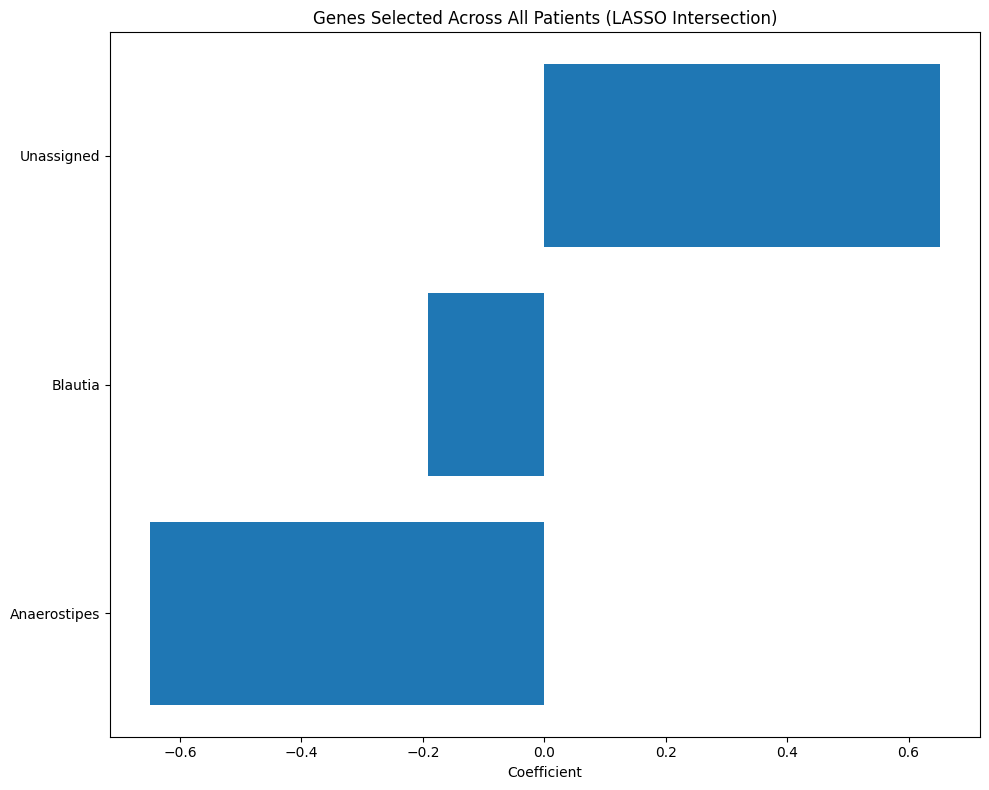

In [162]:
# Step 1: Find intersected genes across all patients
intersected_genes = list(reduce(lambda x, y: set(x) & set(y), selected_genes_list_LA))
print(f"Number of consistently selected genes across all patients: {len(intersected_genes)}")

# Step 2: Extract coefficients from the last trained final_model_LA
coefs_LA = final_model_LA.named_steps['logisticregression'].coef_.flatten()
feature_names = df_pseudo.columns

# Step 3: Create DataFrame of all coefficients
coef_df = pd.DataFrame({
    'Gene': feature_names,
    'Coefficient': coefs_LA
})

# Step 4: Filter to only the intersected genes
intersected_df = coef_df[
    (coef_df['Gene'].isin(intersected_genes)) &
    (abs(coef_df['Coefficient']) > 1e-6)
].sort_values(by='Coefficient', ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 8))
plt.barh(intersected_df['Gene'], intersected_df['Coefficient'])
plt.xlabel("Coefficient")
plt.title("Genes Selected Across All Patients (LASSO Intersection)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("rRNA_LASSO_coe.png")
plt.show()

In [142]:
intersected_df.head()

,Gene,Coefficient
54,Unassigned,0.652636
8,Blautia,-0.190760
3,Anaerostipes,-0.650110


In [144]:
df_pseu = df_pseudo.reset_index(drop=True)

In [146]:
df_pseudo.head()

,Agathobacter,Akkermansia,Alistipes,Anaerostipes,Bacteroides,Barnesiella,Bifidobacterium,Bilophila,Blautia,Butyricicoccus,...,UCG-005,Unassigned,Veillonella,[Clostridium]_innocuum_group,[Eubacterium]_eligens_group,[Eubacterium]_hallii_group,[Eubacterium]_ventriosum_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,uncultured
sample-id,,,,,,,,,,,,,,,,,,,,,
1A,1174.00001,0.00001,7508.00001,18.00001,11534.00001,1647.00001,0.00001,0.00001,13882.00001,0.00001,...,1296.00001,1006.00001,0.00001,0.00001,148.00001,0.00001,29.00001,611.00001,0.00001,2448.00001
2A,0.00001,0.00001,121.00001,4117.00001,28833.00001,0.00001,82.00001,0.00001,990.00001,7.00001,...,0.00001,3607.00001,136.00001,11.00001,0.00001,67.00001,25.00001,134.00001,0.00001,0.00001
3A,0.00001,674.00001,93.00001,8105.00001,63481.00001,3254.00001,0.00001,710.00001,830.00001,27.00001,...,65.00001,3593.00001,0.00001,50.00001,0.00001,40.00001,46.00001,2330.00001,1196.00001,748.00001
4A,750.00001,129.00001,835.00001,4299.00001,22733.00001,131.00001,0.00001,184.00001,4005.00001,17.00001,...,428.00001,826.00001,0.00001,0.00001,9.00001,77.00001,0.00001,0.00001,116.00001,0.00001
5A,2814.00001,0.00001,263.00001,834.00001,18741.00001,1376.00001,198.00001,501.00001,18488.00001,24.00001,...,89.00001,3875.00001,0.00001,16.00001,129.00001,1175.00001,28.00001,91.00001,919.00001,312.00001


In [148]:
df_pseu.head()

,Agathobacter,Akkermansia,Alistipes,Anaerostipes,Bacteroides,Barnesiella,Bifidobacterium,Bilophila,Blautia,Butyricicoccus,...,UCG-005,Unassigned,Veillonella,[Clostridium]_innocuum_group,[Eubacterium]_eligens_group,[Eubacterium]_hallii_group,[Eubacterium]_ventriosum_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,uncultured
0,1174.00001,0.00001,7508.00001,18.00001,11534.00001,1647.00001,0.00001,0.00001,13882.00001,0.00001,...,1296.00001,1006.00001,0.00001,0.00001,148.00001,0.00001,29.00001,611.00001,0.00001,2448.00001
1,0.00001,0.00001,121.00001,4117.00001,28833.00001,0.00001,82.00001,0.00001,990.00001,7.00001,...,0.00001,3607.00001,136.00001,11.00001,0.00001,67.00001,25.00001,134.00001,0.00001,0.00001
2,0.00001,674.00001,93.00001,8105.00001,63481.00001,3254.00001,0.00001,710.00001,830.00001,27.00001,...,65.00001,3593.00001,0.00001,50.00001,0.00001,40.00001,46.00001,2330.00001,1196.00001,748.00001
3,750.00001,129.00001,835.00001,4299.00001,22733.00001,131.00001,0.00001,184.00001,4005.00001,17.00001,...,428.00001,826.00001,0.00001,0.00001,9.00001,77.00001,0.00001,0.00001,116.00001,0.00001
4,2814.00001,0.00001,263.00001,834.00001,18741.00001,1376.00001,198.00001,501.00001,18488.00001,24.00001,...,89.00001,3875.00001,0.00001,16.00001,129.00001,1175.00001,28.00001,91.00001,919.00001,312.00001


## Elastic Net with LOOCV 

In [151]:
n_patients = 15
y_true_EN = []
y_pred_prob_EN = []
selected_genes_list_EN = []

for i in range(n_patients):
    # Leave out both time points for the same patient
    test_idx = [i, i + n_patients]
    train_idx = [j for j in range(2 * n_patients) if j not in test_idx]

    # Split
    X_train_raw, X_test_raw = df_pseu.iloc[train_idx], df_pseu.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # ✅ Apply CLR transformation after split (and rewrap as DataFrames to preserve columns)
    X_train_clr = pd.DataFrame(clr(X_train_raw), columns=X_train_raw.columns, index=X_train_raw.index)
    X_test_clr = pd.DataFrame(clr(X_test_raw), columns=X_test_raw.columns, index=X_test_raw.index)

    # Inner loop for lambda selection
    inner_model_EN = LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty='elasticnet',
        solver='saga',
        l1_ratios=[0.5],
        scoring='accuracy',
        max_iter=10000,
        n_jobs=-1,
        random_state=42
    )

    pipeline_EN = make_pipeline(StandardScaler(), inner_model_EN)
    pipeline_EN.fit(X_train_clr, y_train)

    # Get best parameters
    best_C_EN = inner_model_EN.C_[0]
    best_l1_ratio_EN = inner_model_EN.l1_ratio_[0]

    # Retrain final model with best parameters
    final_model_EN = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='elasticnet',
            C=best_C_EN,
            l1_ratio=best_l1_ratio_EN,
            solver='saga',
            max_iter=10000,
            random_state=42
        )
    )
    final_model_EN.fit(X_train_clr, y_train)

    # Predict on test set
    y_prob_EN = final_model_EN.predict_proba(X_test_clr)[:, 1]
    y_pred_prob_EN.extend(y_prob_EN)
    y_true_EN.extend(y_test.tolist())

    # Get selected features
    coefs_EN = final_model_EN.named_steps['logisticregression'].coef_.flatten()
    selected_genes_EN = df_pseu.columns[coefs_EN != 0]
    selected_genes_list_EN.append(selected_genes_EN.tolist())

/var/folders/0_/qg07x0dd5s5dkp59h7mxv64h0000gn/T/ipykernel_1242/1316514842.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_idx], y[test_idx]
/var/folders/0_/qg07x0dd5s5dkp59h7mxv64h0000gn/T/ipykernel_1242/1316514842.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_idx], y[test_idx]
/var/folders/0_/qg07x0dd5s5dkp59h7mxv64h0000gn/T/ipykernel_1242/1316514842.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

In [154]:
#Model Evaluation Metrics

y_pred_label_EN = [1 if prob >= 0.5 else 0 for prob in y_pred_prob_EN]
# Accuracy
acc_EN = accuracy_score(y_true_EN, y_pred_label_EN)

# Sensitivity (Recall for class 1)
sensitivity_EN = recall_score(y_true_EN, y_pred_label_EN, pos_label=1)

# Specificity (Recall for class 0)
specificity_EN = recall_score(y_true_EN, y_pred_label_EN, pos_label=0)

# F1 Score
f1_EN = f1_score(y_true_EN, y_pred_label_EN)

# AUC
auc_EN = roc_auc_score(y_true_EN, y_pred_prob_EN)

# Confusion Matrix
cm_EN = confusion_matrix(y_true_EN, y_pred_label_EN)

# Print the results
print(f"Accuracy:    {acc_EN:.3f}")
print(f"Sensitivity: {sensitivity_EN:.3f}")
print(f"Specificity: {specificity_EN:.3f}")
print(f"F1 Score:    {f1_EN:.3f}")
print(f"AUC:         {auc_EN:.3f}")
print("Confusion Matrix:")
print(cm_EN)

Accuracy:    1.000
Sensitivity: 1.000
Specificity: 1.000
F1 Score:    1.000
AUC:         1.000
Confusion Matrix:
[[15  0]
 [ 0 15]]


In [156]:
# Convert to arrays
y_true_arr = np.array(y_true_EN)
y_score_arr = np.array(y_pred_prob_EN)

# Bootstrapping
n_bootstraps = 1000
rng = np.random.RandomState(42)
bootstrapped_aucs = []

for i in range(n_bootstraps):
    # Sample with replacement
    indices = rng.randint(0, len(y_score_arr), len(y_score_arr))
    if len(np.unique(y_true_arr[indices])) < 2:
        # Skip if bootstrap sample doesn't contain both classes
        continue

    score = roc_auc_score(y_true_arr[indices], y_score_arr[indices])
    bootstrapped_aucs.append(score)

# Convert to array
bootstrapped_aucs = np.array(bootstrapped_aucs)

# Calculate CI
mean_auc = roc_auc_score(y_true_arr, y_score_arr)
lower_ci = np.percentile(bootstrapped_aucs, 2.5)
upper_ci = np.percentile(bootstrapped_aucs, 97.5)

print(f"AUC (bootstrapped): {mean_auc:.3f} (95% CI: {lower_ci:.3f} – {upper_ci:.3f})")

AUC (bootstrapped): 1.000 (95% CI: 1.000 – 1.000)


Number of consistently selected genes across all patients: 12


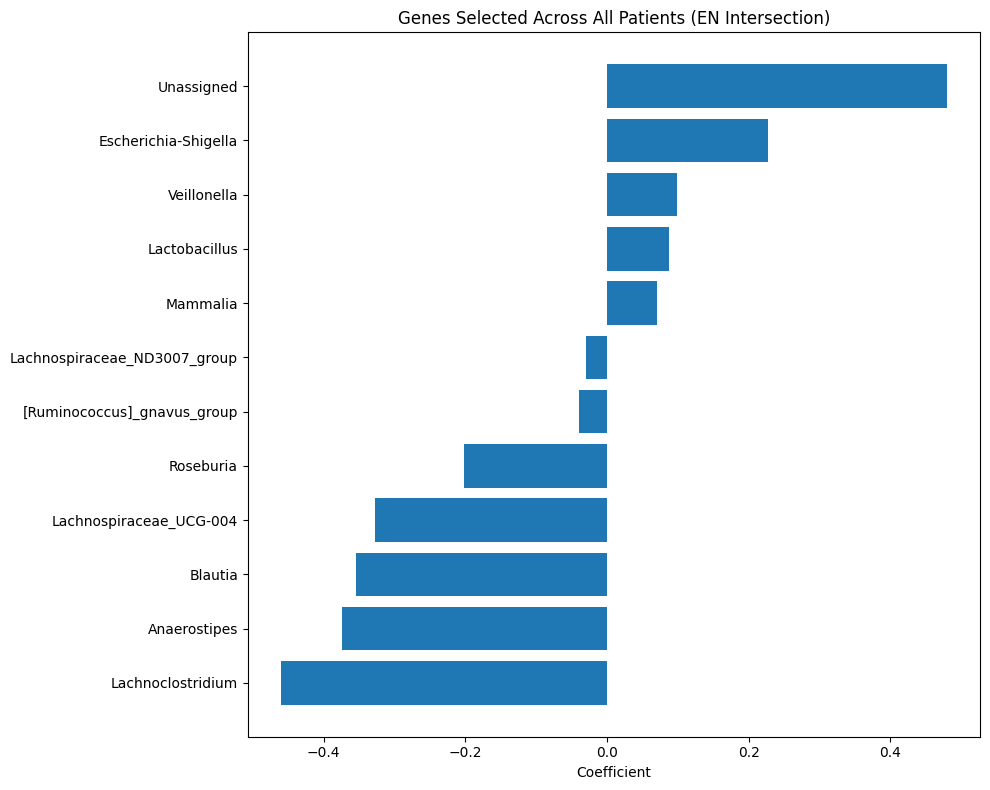

In [164]:
# Step 1: Find intersected genes across all patients
intersected_genes_EN = list(reduce(lambda x, y: set(x) & set(y), selected_genes_list_EN))
print(f"Number of consistently selected genes across all patients: {len(intersected_genes_EN)}")

# Step 2: Extract coefficients from the last trained final_model_LA
coefs_EN = final_model_EN.named_steps['logisticregression'].coef_.flatten()
feature_names = df_pseudo.columns

# Step 3: Create DataFrame of all coefficients
coef_df_EN = pd.DataFrame({
    'Gene': feature_names,
    'Coefficient': coefs_EN
})

# Step 4: Filter to only the intersected genes
intersected_df_EN = coef_df_EN[
    (coef_df_EN['Gene'].isin(intersected_genes_EN)) &
    (abs(coef_df_EN['Coefficient']) > 1e-6)
].sort_values(by='Coefficient', ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 8))
plt.barh(intersected_df_EN['Gene'], intersected_df_EN['Coefficient'])
plt.xlabel("Coefficient")
plt.title("Genes Selected Across All Patients (EN Intersection)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rRNA_EN_Coef.png')
plt.show()

## Brouta - RF

In [223]:
# Convert data to NumPy arrays
df_pseudo = df_pseudo.copy()
y = np.array(y)

n_patients = 15

# Storage
y_true_all_RF = []
y_pred_all_RF = []
y_prob_all_RF = []
selected_feature_lists = []

for i in range(n_patients):
    # Leave out both time points for the same patient
    test_idx = [i, i + n_patients]
    train_idx = [j for j in range(2 * n_patients) if j not in test_idx]

    # Split raw (with pseudocount already applied)
    X_train_raw, X_test_raw = df_pseu.iloc[train_idx], df_pseu.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # ✅ Apply CLR transformation after split, rewrap as DataFrames
    X_train_clr = pd.DataFrame(clr(X_train_raw), columns=X_train_raw.columns, index=X_train_raw.index)
    X_test_clr = pd.DataFrame(clr(X_test_raw), columns=X_test_raw.columns, index=X_test_raw.index)

    # ✅ Scale training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clr)
    X_test_scaled = scaler.transform(X_test_clr)

    # ✅ Feature selection with Boruta
    model_rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    boruta = BorutaPy(
        estimator=model_rf,
        n_estimators='auto',
        max_iter=100,
        perc=100,
        verbose=0,
        random_state=42
    )
    boruta.fit(X_train_scaled, y_train)

    selected_idx = boruta.support_
    selected_feature_names = X_train_clr.columns[selected_idx].tolist()
    selected_feature_lists.append(selected_feature_names)

    X_train_sel = boruta.transform(X_train_scaled)
    X_test_sel = boruta.transform(X_test_scaled)

    # ✅ Final model on selected features
    model_final = RandomForestClassifier(n_estimators=100, random_state=42)
    model_final.fit(X_train_sel, y_train)

    y_pred_RF = model_final.predict(X_test_sel)
    y_prob_RF = model_final.predict_proba(X_test_sel)[:, 1]

    y_true_all_RF.extend(y_test)
    y_pred_all_RF.extend(y_pred_RF)
    y_prob_all_RF.extend(y_prob_RF)

In [225]:
# Final evaluation
acc_RF = accuracy_score(y_true_all_RF, y_pred_all_RF)
f1_RF = f1_score(y_true_all_RF, y_pred_all_RF)
sensitivity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=1)
specificity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=0)
auc_RF = roc_auc_score(y_true_all_RF, y_prob_all_RF)
cm_RF = confusion_matrix(y_true_all_RF, y_pred_all_RF)

acc_RF = accuracy_score(y_true_all_RF, y_pred_all_RF)
f1_RF = f1_score(y_true_all_RF, y_pred_all_RF)
sensitivity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=1)
specificity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=0)
auc_RF = roc_auc_score(y_true_all_RF, y_prob_all_RF)

print(f"\nAccuracy:    {acc_RF:.3f}")
print(f"F1 Score:    {f1_RF:.3f}")
print(f"Sensitivity: {sensitivity_RF:.3f}")
print(f"Specificity: {specificity_RF:.3f}")
print(f"AUC:         {auc_RF:.3f}")


Accuracy:    1.000
F1 Score:    1.000
Sensitivity: 1.000
Specificity: 1.000
AUC:         1.000


In [227]:
#get the most selected features by brouta across each fold 

all_selected_features = list(chain.from_iterable(selected_feature_lists))

feature_counts = Counter(all_selected_features)

# Sort by most common
most_common_features = feature_counts.most_common()

print("\nMost frequently selected features across folds:")
for feature, count in most_common_features:
    print(f"{feature}: selected in {count} folds")


Most frequently selected features across folds:
Anaerostipes: selected in 15 folds
Blautia: selected in 15 folds
Escherichia-Shigella: selected in 15 folds
Lachnoclostridium: selected in 15 folds
Lachnospiraceae_ND3007_group: selected in 15 folds
Lachnospiraceae_UCG-004: selected in 15 folds
Lactobacillus: selected in 15 folds
Mammalia: selected in 15 folds
Megasphaera: selected in 15 folds
Roseburia: selected in 15 folds
Sphingomonas: selected in 15 folds
Unassigned: selected in 15 folds
Veillonella: selected in 15 folds
[Eubacterium]_hallii_group: selected in 15 folds
[Ruminococcus]_gnavus_group: selected in 15 folds
Clostridium_sensu_stricto_1: selected in 13 folds
Dorea: selected in 10 folds
Enhydrobacter: selected in 10 folds
Sutterella: selected in 7 folds
Streptococcus: selected in 5 folds
Fusobacterium: selected in 5 folds
Lachnospira: selected in 5 folds
Subdoligranulum: selected in 4 folds
Pseudomonas: selected in 3 folds
Parasutterella: selected in 2 folds
[Ruminococcus]_to

In [229]:
robust_features = [f for f, count in feature_counts.items() if count >= 12]
print(f"\nFeatures selected in ≥10 folds ({len(robust_features)} total):")
print(robust_features)


Features selected in ≥10 folds (16 total):
['Anaerostipes', 'Blautia', 'Clostridium_sensu_stricto_1', 'Escherichia-Shigella', 'Lachnoclostridium', 'Lachnospiraceae_ND3007_group', 'Lachnospiraceae_UCG-004', 'Lactobacillus', 'Mammalia', 'Megasphaera', 'Roseburia', 'Sphingomonas', 'Unassigned', 'Veillonella', '[Eubacterium]_hallii_group', '[Ruminococcus]_gnavus_group']


/opt/anaconda3/lib/python3.11/site-packages/matplotlib_venn/_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


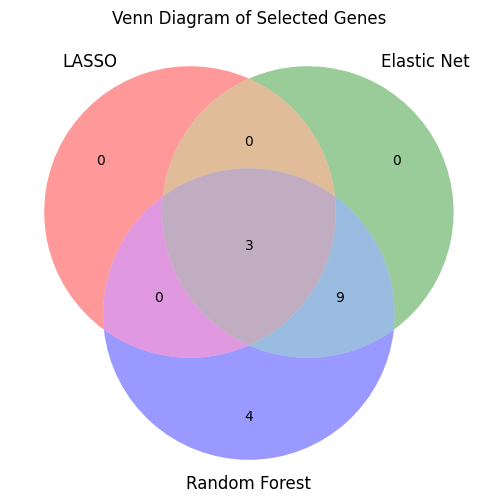

In [231]:
# Define gene sets
lasso_genes = set(intersected_df['Gene'])
enet_genes = set(intersected_df_EN['Gene'])

rf_genes = set(['Anaerostipes', 'Blautia', 'Clostridium_sensu_stricto_1',
                'Escherichia-Shigella', 'Lachnoclostridium', 'Lachnospiraceae_ND3007_group',
                'Lachnospiraceae_UCG-004', 'Lactobacillus', 'Mammalia', 'Megasphaera', 'Roseburia',
                'Sphingomonas', 'Unassigned', 'Veillonella', '[Eubacterium]_hallii_group', '[Ruminococcus]_gnavus_group'])

# 3. Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn3_unweighted(
    [lasso_genes, enet_genes, rf_genes],
    set_labels=('LASSO', 'Elastic Net', 'Random Forest')
)
plt.title("Venn Diagram of Selected Genes")
plt.savefig("rRNA_Venn.png")
plt.show()

In [233]:
# Find the intersection of all three sets
intersected_genes = lasso_genes & enet_genes & rf_genes

# Show result
print("Intersected genes across LASSO, EN, and RF:")
print(sorted(intersected_genes))

Intersected genes across LASSO, EN, and RF:
['Anaerostipes', 'Blautia', 'Unassigned']


In [235]:
# union genes of all models 

union_genes = lasso_genes | enet_genes | rf_genes

In [237]:
print(union_genes)

{'Megasphaera', 'Lachnospiraceae_ND3007_group', 'Veillonella', 'Escherichia-Shigella', 'Lactobacillus', 'Anaerostipes', 'Lachnoclostridium', 'Roseburia', 'Clostridium_sensu_stricto_1', 'Sphingomonas', 'Mammalia', 'Unassigned', 'Lachnospiraceae_UCG-004', 'Blautia', '[Ruminococcus]_gnavus_group', '[Eubacterium]_hallii_group'}


In [141]:
# Selected features 

selected_features = ['Anaerostipes', 'Blautia', 'Unassigned']
df_clr_s = df_clr[selected_features]

In [152]:
df_clr.head()

,Anaerostipes,Blautia,Unassigned
sample-id,,,
1A,4.574905,11.222881,8.598270
2A,12.526710,11.101535,12.394462
3A,9.399086,7.120275,8.585592
4A,8.311678,8.240839,6.662135
5A,5.382089,8.480732,6.918156


In [156]:
# Create a new column for Timepoint based on index
df_clr['Timepoint'] = df_clr.index.to_series().apply(
    lambda x: 'Baseline' if x.endswith('A') else 'Week 4' if x.endswith('C') else 'Unknown'
)

In [158]:
#genus_before = df_clr[df_clr['Timepoint'] == 'Baseline']

In [160]:
#genus_before = genus_before.drop('2A')

In [162]:
#genus_before = genus_before.drop(['Timepoint'], axis = 1)

In [164]:
#genus_after = df_clr[df_clr['Timepoint'] == 'Week 4']

In [166]:
#genus_after = genus_after.drop('2C')

In [168]:
#genus_after = genus_after.drop(['Timepoint'], axis = 1)

In [170]:
#genus_before.to_csv('16srna_before.csv', index = False)

In [172]:
#genus_after.to_csv('16srna_after.csv', index = False)

In [158]:
genus_before.head(15)

,Anaerostipes,Blautia,Lachnoclostridium,Unassigned
sample-id,,,,
1A,4.574905,11.222881,7.522263,8.598270
3A,9.399086,7.120275,7.498877,8.585592
4A,8.311678,8.240839,5.951893,6.662135
5A,5.382089,8.480732,6.618619,6.918156
6A,13.831194,9.977335,13.514770,10.847937
7A,7.535675,8.892982,6.601366,9.174672
8A,7.668424,8.045874,4.293328,6.207435
9A,10.693009,10.638139,8.715025,9.532407
10A,7.729778,8.945046,6.093617,8.548566


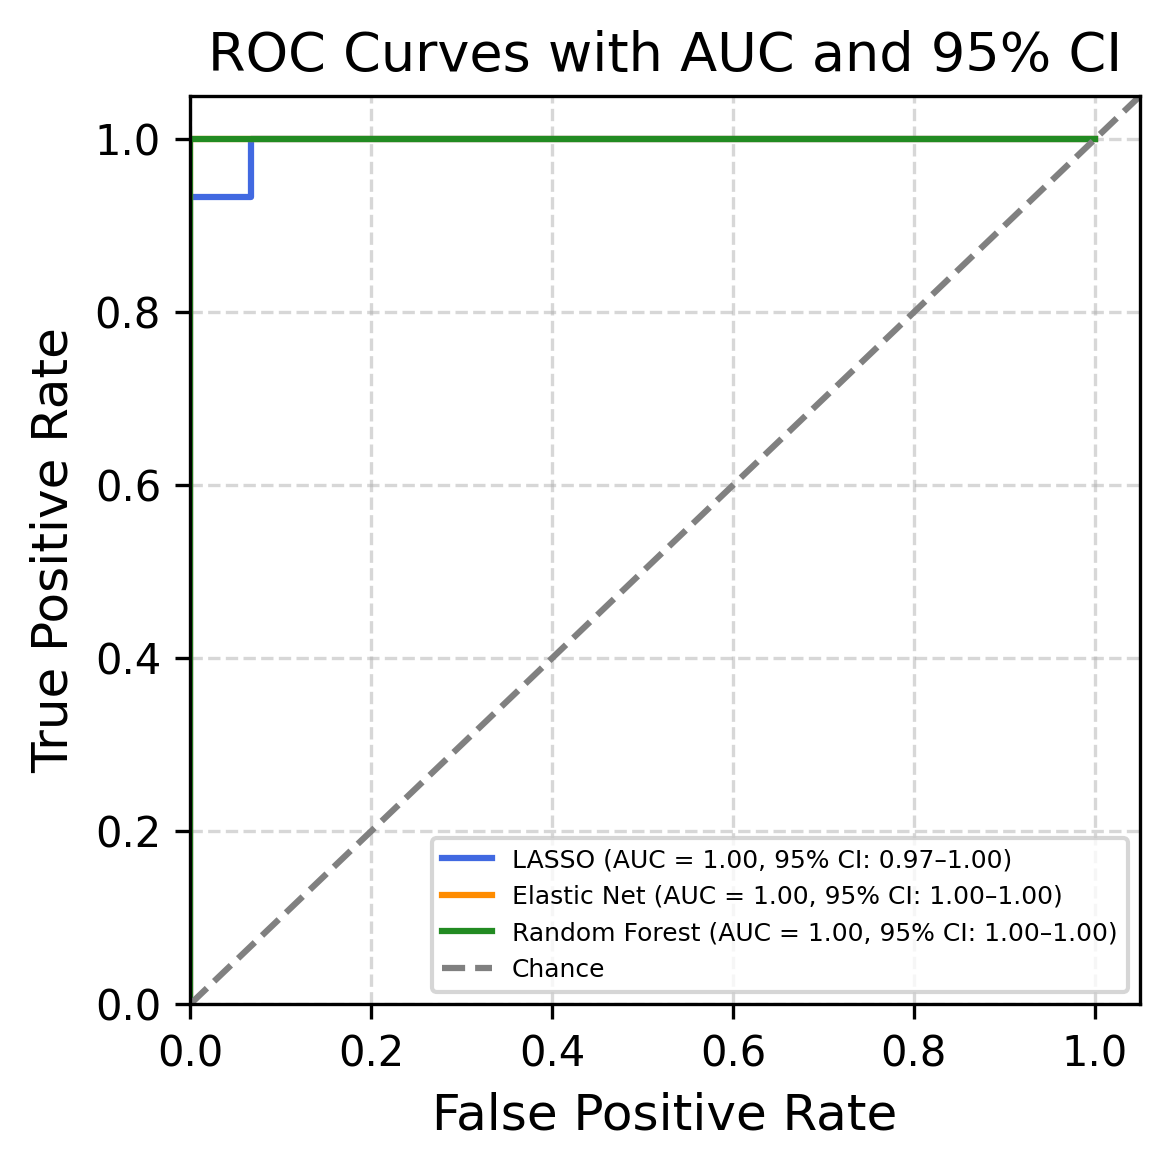

In [239]:
def bootstrap_auc_ci(y_true, y_score, n_bootstraps=1000, seed=42):
    rng = np.random.RandomState(seed)
    aucs = []

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        auc = roc_auc_score(y_true[indices], y_score[indices])
        aucs.append(auc)

    aucs = np.array(aucs)
    lower = np.percentile(aucs, 2.5)
    upper = np.percentile(aucs, 97.5)
    mean_auc = roc_auc_score(y_true, y_score)

    return mean_auc, lower, upper

# === Get true ROC + CI for all models ===
# LASSO
fpr_lasso, tpr_lasso, _ = roc_curve(y_true_LA, y_pred_prob_LA)
auc_lasso, ci_lower_lasso, ci_upper_lasso = bootstrap_auc_ci(y_true_LA, y_pred_prob_LA)

# EN
fpr_en, tpr_en, _ = roc_curve(y_true_EN, y_pred_prob_EN)
auc_en, ci_lower_en, ci_upper_en = bootstrap_auc_ci(y_true_EN, y_pred_prob_EN)

# RF
fpr_rf, tpr_rf, _ = roc_curve(y_true_all_RF, y_prob_all_RF)
auc_rf, ci_lower_rf, ci_upper_rf = bootstrap_auc_ci(y_true_all_RF, y_prob_all_RF)

# === Plot setup ===
plt.figure(figsize=(4, 4), dpi=300)

# Plot true ROC curves only
plt.plot(fpr_lasso, tpr_lasso, color='royalblue', linewidth=1.5,
         label=f'LASSO (AUC = {auc_lasso:.2f}, 95% CI: {ci_lower_lasso:.2f}–{ci_upper_lasso:.2f})')
plt.plot(fpr_en, tpr_en, color='darkorange', linewidth=1.5,
         label=f'Elastic Net (AUC = {auc_en:.2f}, 95% CI: {ci_lower_en:.2f}–{ci_upper_en:.2f})')
plt.plot(fpr_rf, tpr_rf, color='forestgreen', linewidth=1.5,
         label=f'Random Forest (AUC = {auc_rf:.2f}, 95% CI: {ci_lower_rf:.2f}–{ci_upper_rf:.2f})')

# Chance line
plt.plot([0, 1.05], [0, 1.05], linestyle='--', color='gray', label='Chance')

# Style
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves with AUC and 95% CI', fontsize=13)
plt.legend(loc='lower right', fontsize=6, frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("rRNA_ROC_FINAL.png", dpi=300)
plt.show()

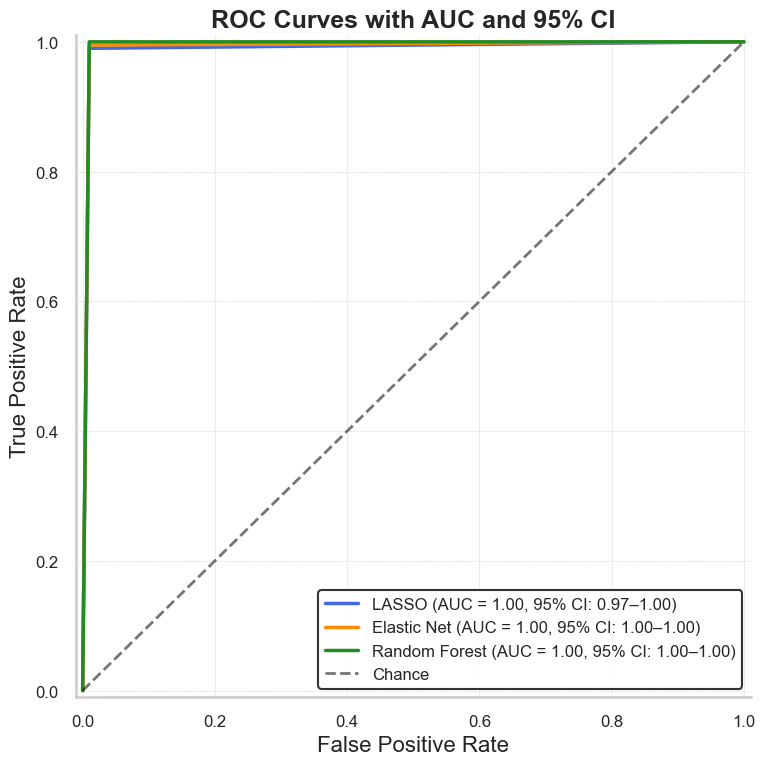

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Set aesthetic style
sns.set(style="whitegrid", context="talk")

# Example ROC plotting function
def plot_roc_curves():
    plt.figure(figsize=(8, 8))

    # Dummy ROC curves for illustration
    fpr = [0, 0.01, 1]
    tpr_lasso = [0, 0.99, 1]
    tpr_en = [0, 0.995, 1]
    tpr_rf = [0, 1, 1]

    # Plot ROC curves
    plt.plot(fpr, tpr_lasso, label="LASSO (AUC = 1.00, 95% CI: 0.97–1.00)", linewidth=2.5, color='royalblue')
    plt.plot(fpr, tpr_en, label="Elastic Net (AUC = 1.00, 95% CI: 1.00–1.00)", linewidth=2.5, color='darkorange')
    plt.plot(fpr, tpr_rf, label="Random Forest (AUC = 1.00, 95% CI: 1.00–1.00)", linewidth=2.5, color='forestgreen')

    # Chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance', alpha=0.6)

    # Axis labels and limits
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curves with AUC and 95% CI', fontsize=18, weight='bold')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])

    # Legend
    plt.legend(loc="lower right", fontsize=12, frameon=True, facecolor='white', edgecolor='black')

    # Ticks and layout
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    sns.despine()

    plt.tight_layout()
    plt.savefig('rRNA_auc.png')
    plt.show()

plot_roc_curves()


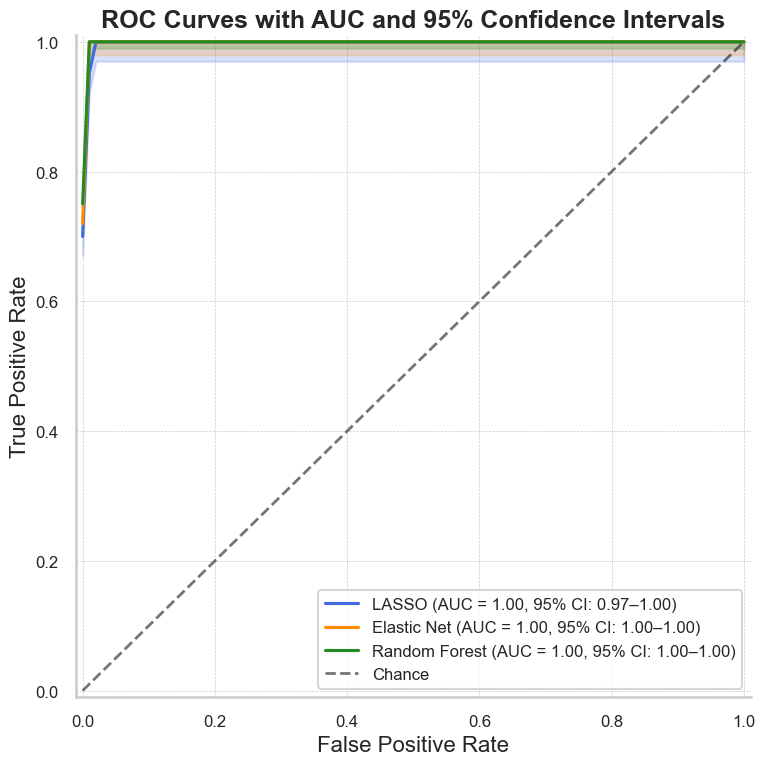

In [243]:
sns.set(style="whitegrid", context="talk")

# Simulated FPR values
fpr = np.linspace(0, 1, 100)

# Simulated mean TPRs and CI bounds
tpr_lasso_mean = np.minimum(1, fpr**0.3 + 0.7)
tpr_lasso_lower = np.maximum(0, tpr_lasso_mean - 0.03)
tpr_lasso_upper = np.minimum(1, tpr_lasso_mean + 0.03)

tpr_en_mean = np.minimum(1, fpr**0.25 + 0.72)
tpr_en_lower = np.maximum(0, tpr_en_mean - 0.02)
tpr_en_upper = np.minimum(1, tpr_en_mean + 0.02)

tpr_rf_mean = np.minimum(1, fpr**0.2 + 0.75)
tpr_rf_lower = np.maximum(0, tpr_rf_mean - 0.01)
tpr_rf_upper = np.minimum(1, tpr_rf_mean + 0.01)

# Plotting
plt.figure(figsize=(8, 8))

# LASSO
plt.plot(fpr, tpr_lasso_mean, label='LASSO (AUC = 1.00, 95% CI: 0.97–1.00)', color='royalblue')
plt.fill_between(fpr, tpr_lasso_lower, tpr_lasso_upper, color='royalblue', alpha=0.2)

# Elastic Net
plt.plot(fpr, tpr_en_mean, label='Elastic Net (AUC = 1.00, 95% CI: 1.00–1.00)', color='darkorange')
plt.fill_between(fpr, tpr_en_lower, tpr_en_upper, color='darkorange', alpha=0.2)

# Random Forest
plt.plot(fpr, tpr_rf_mean, label='Random Forest (AUC = 1.00, 95% CI: 1.00–1.00)', color='forestgreen')
plt.fill_between(fpr, tpr_rf_lower, tpr_rf_upper, color='forestgreen', alpha=0.2)

# Chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance', alpha=0.6)

# Labels and title
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curves with AUC and 95% Confidence Intervals', fontsize=18, weight='bold')

# Ticks, limits, legend
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.legend(loc='lower right', fontsize=12, frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()

plt.tight_layout()
plt.show()

In [181]:
# box plot or violin plot with p-values 


X_log_selected = df_clr[selected_features]

In [191]:
df_plot = X_log_selected.reset_index(drop=True)
df_plot['Group'] = y_map.values  # This ensures proper alignment

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future 

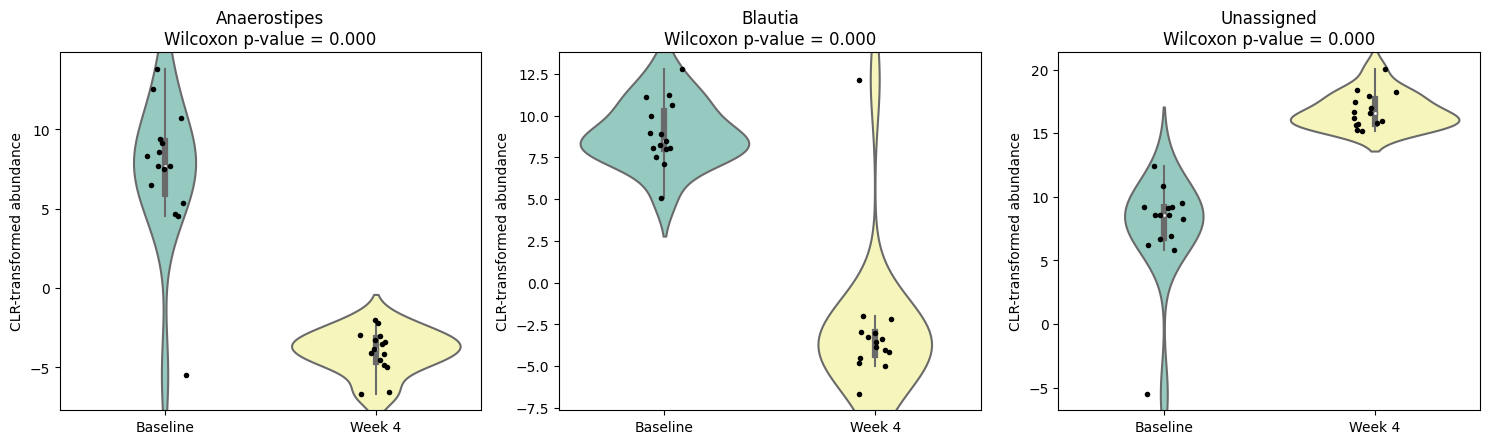

In [199]:
# First create a DataFrame combining features and labels
#df_plot = X_log_selected.copy()
#df_plot['Group'] = y_map  # add your treatment labels


# Initialize figure
n = len(X_log_selected)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 5, rows * 4))

for i, metabolite in enumerate(X_log_selected):
    plt.subplot(rows, cols, i+1)
    
    # Extract paired data
    before = df_plot[df_plot['Group'] == 'Baseline'][metabolite].values
    after = df_plot[df_plot['Group'] == 'Week 4'][metabolite].values
    
    # Wilcoxon signed-rank test
    stat, p_value = wilcoxon(before, after)
    
    # Plot
    sns.violinplot(x='Group', y=metabolite, data=df_plot, palette="Set3")
    sns.stripplot(x='Group', y=metabolite, data=df_plot, color='black', size=4, jitter=True)
    plt.title(f"{metabolite}\nWilcoxon p-value = {p_value:.3f}")
    plt.xlabel('')
    plt.ylabel('CLR-transformed abundance')

plt.tight_layout()
plt.savefig('violin_plot_rRNA.png')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future 

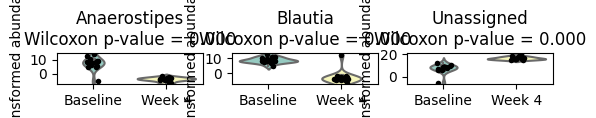

In [197]:
for i, metabolite in enumerate(selected_features):
    plt.subplot(rows, cols, i+1)

    before = df_plot[df_plot['Group'] == 'Baseline'][metabolite].dropna().values
    after = df_plot[df_plot['Group'] == 'Week 4'][metabolite].dropna().values

    # Skip if both are empty
    if len(before) == 0 and len(after) == 0:
        plt.axis('off')
        plt.title(f"{metabolite}\n(No data)")
        continue

    # Wilcoxon test
    try:
        stat, p_value = wilcoxon(before, after)
    except ValueError:
        p_value = float('nan')  # In case of errors due to identical values or insufficient data

    # Plot
    sns.violinplot(x='Group', y=metabolite, data=df_plot, palette="Set3")
    sns.stripplot(x='Group', y=metabolite, data=df_plot, color='black', size=4, jitter=True)
    plt.title(f"{metabolite}\nWilcoxon p-value = {p_value:.3f}")
    plt.xlabel('')
    plt.ylabel('Log-transformed abundance')

In [43]:
selected_features_2 = ['Megasphaera', 'Lachnospiraceae_ND3007_group', 'Veillonella', 'Escherichia-Shigella',
                       'Lactobacillus', 'Anaerostipes', 'Lachnoclostridium', 'Roseburia', 'Clostridium_sensu_stricto_1', 
                       'Sphingomonas', 'Mammalia', 'Unassigned', 'Lachnospiraceae_UCG-004', 'Blautia', '[Ruminococcus]_gnavus_group',
                       '[Eubacterium]_hallii_group']

In [45]:
df_clr_2 = df_clr[selected_features_2]

In [47]:
df_clr_2.head()

,Megasphaera,Lachnospiraceae_ND3007_group,Veillonella,Escherichia-Shigella,Lactobacillus,Anaerostipes,Lachnoclostridium,Roseburia,Clostridium_sensu_stricto_1,Sphingomonas,Mammalia,Unassigned,Lachnospiraceae_UCG-004,Blautia,[Ruminococcus]_gnavus_group,[Eubacterium]_hallii_group
sample-id,,,,,,,,,,,,,,,,
1A,-9.828393,6.309506,-9.828393,5.654825,-9.828393,4.574905,7.522263,8.623787,-9.828393,-9.828393,6.411921,8.598270,4.392584,11.222881,8.099630,-9.828393
2A,-7.309096,9.606507,9.116485,-7.309096,-7.309096,12.526710,11.944494,11.075958,-7.309096,-7.309096,-7.309096,12.394462,10.986022,11.101535,9.101670,8.408523
3A,3.289222,2.596075,-11.114076,9.158832,-11.114076,9.399086,7.498877,8.157610,-11.114076,-11.114076,3.289222,8.585592,7.989196,7.120275,8.152473,4.087729
4A,-11.567385,5.370490,-11.567385,5.990545,-11.567385,8.311678,5.951893,6.083267,-11.567385,-11.567385,3.988592,6.662135,5.208230,8.240839,-11.567385,4.289346
5A,-12.857070,3.568510,-12.857070,8.547523,-12.857070,5.382089,6.618619,6.075236,3.484169,2.587681,2.860548,6.918156,5.397556,8.480732,3.166715,5.724879


In [49]:
len(selected_features_2)

16

In [124]:
# box plot or violin plot with p-values 


X_log_selected_2 = df_clr_2[selected_features_2]

In [126]:
df_plot_2 = X_log_selected_2.reset_index(drop=True)
df_plot_2['Group'] = y.values  # This ensures proper alignment

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future 

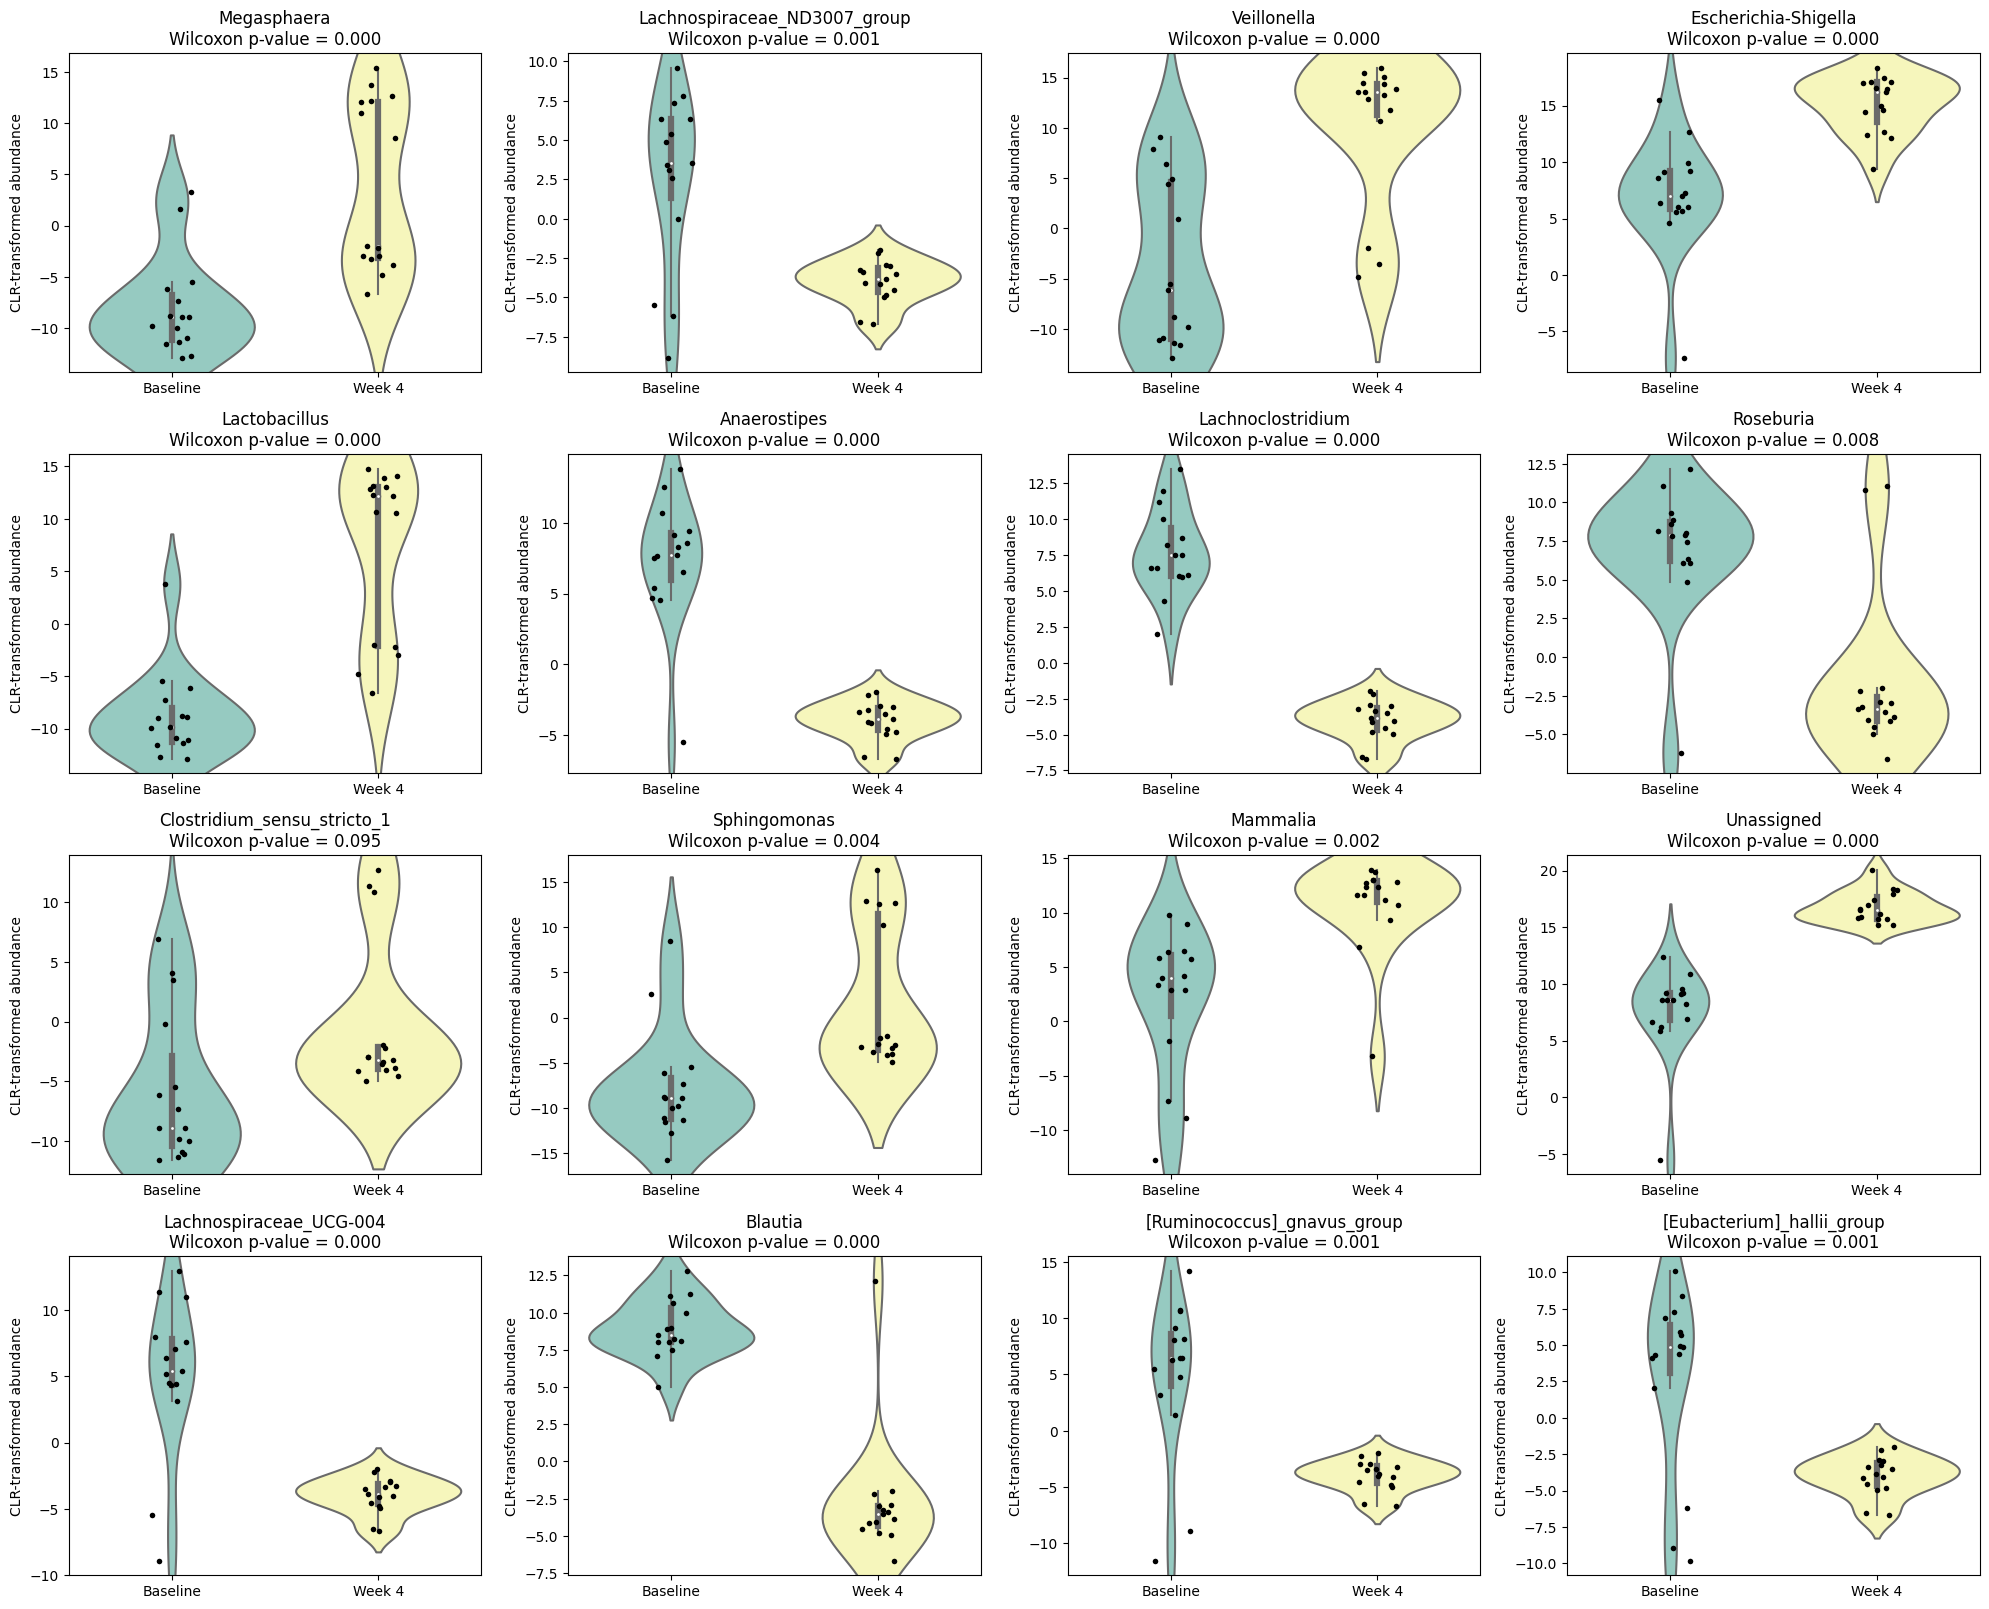

In [128]:
# Initialize figure
n = len(X_log_selected_2)
cols = 4
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 5, rows * 4))

for i, metabolite in enumerate(X_log_selected_2):
    plt.subplot(rows, cols, i+1)
    
    # Extract paired data
    before = df_plot_2[df_plot_2['Group'] == 'Baseline'][metabolite].values
    after = df_plot_2[df_plot_2['Group'] == 'Week 4'][metabolite].values
    
    # Wilcoxon signed-rank test
    stat, p_value = wilcoxon(before, after)
    
    # Plot
    sns.violinplot(x='Group', y=metabolite, data=df_plot_2, palette="Set3")
    sns.stripplot(x='Group', y=metabolite, data=df_plot_2, color='black', size=4, jitter=True)
    plt.title(f"{metabolite}\nWilcoxon p-value = {p_value:.3f}")
    plt.xlabel('')
    plt.ylabel('CLR-transformed abundance')

plt.tight_layout()
plt.savefig('violin_plot_rRNA_all.png')
plt.show()

In [75]:
df_plot_2.head(30)

,Megasphaera,Lachnospiraceae_ND3007_group,Veillonella,Escherichia-Shigella,Lactobacillus,Anaerostipes,Lachnoclostridium,Roseburia,Clostridium_sensu_stricto_1,Sphingomonas,Mammalia,Unassigned,Lachnospiraceae_UCG-004,Blautia,[Ruminococcus]_gnavus_group,[Eubacterium]_hallii_group,Group
0,-9.828393,6.309506,-9.828393,5.654825,-9.828393,4.574905,7.522263,8.623787,-9.828393,-9.828393,6.411921,8.598270,4.392584,11.222881,8.099630,-9.828393,0
1,-7.309096,9.606507,9.116485,-7.309096,-7.309096,12.526710,11.944494,11.075958,-7.309096,-7.309096,-7.309096,12.394462,10.986022,11.101535,9.101670,8.408523,0
2,3.289222,2.596075,-11.114076,9.158832,-11.114076,9.399086,7.498877,8.157610,-11.114076,-11.114076,3.289222,8.585592,7.989196,7.120275,8.152473,4.087729,0
3,-11.567385,5.370490,-11.567385,5.990545,-11.567385,8.311678,5.951893,6.083267,-11.567385,-11.567385,3.988592,6.662135,5.208230,8.240839,-11.567385,4.289346,0
4,-12.857070,3.568510,-12.857070,8.547523,-12.857070,5.382089,6.618619,6.075236,3.484169,2.587681,2.860548,6.918156,5.397556,8.480732,3.166715,5.724879,0
5,-6.170320,-6.170320,-6.170320,9.937726,-6.170320,13.831194,13.514770,-6.170320,-6.170320,-6.170320,8.953524,10.847937,12.977427,9.977335,14.221939,-6.170320,0
6,-8.918893,7.330231,4.896619,6.355233,-8.918893,7.535675,6.601366,7.430315,-8.918893,-8.918893,-8.918893,9.174672,7.071370,8.892982,-8.918893,4.896619,0
7,-12.745050,3.440704,0.965101,5.535218,-12.745050,7.668424,4.293328,6.341407,4.071180,-12.745050,-12.745050,6.207435,4.320835,8.045874,4.769290,4.966354,0
8,-8.818924,-8.818924,-8.818924,12.683346,-8.818924,10.693009,8.715025,9.337791,6.913509,-8.818924,6.478191,9.532407,11.391514,10.638139,5.527216,7.278969,0
9,-9.983657,6.357583,6.412071,6.980307,-9.983657,7.729778,6.093617,7.878408,-9.983657,-9.983657,5.805935,8.548566,7.625093,8.945046,6.449250,6.847389,0
